**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
a = np.array([1, 2, 3, 4, 5])
a[np.array([0, 2, 4])]

array([1, 3, 5])

In [63]:
#%%pycodestyle
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances

import numpy as np

# default weight='uniform’ : uniform weights.
# All points in each neighborhood are weighted equally
# metric : string or callable, default ‘minkowski’ with default p=2
# 'brute’ will use a brute-force search
# ‘kd_tree’ will use KDTree


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        NeighborsBase.__init__(self)
        KNeighborsMixin.__init__(self)
        SupervisedIntegerMixin.__init__(self)
        ClassifierMixin.__init__(self)
        self.__n_neighbors = n_neighbors
        self.__algorithm = algorithm
        self.__train_x = None
        self.__train_y = None
        self.__train_x_tree = None
        self.__classes = None
        self.__metric = metric
        assert metric in {'minkowski', 'cosine'}, "unsupported metric"
        assert algorithm in {'brute', 'kd_tree'}, "unsupported algorithm"

    def fit(self, x_array, y_array):
        # Fit the model using X as training data and y as target values
        if self.__algorithm == 'brute':
            self.__train_x = x_array
        elif self.__algorithm == 'kd_tree':
            self.__train_x_tree = KDTree(x_array, metric=self.__metric)
        self.__train_y = y_array
        self.__classes = np.sort(np.unique(y_array))

    def get_k_neighbors_indexes(self, x_array):
        if self.__algorithm == "brute":
            assert self.__train_x is not None, "you should call fit before"
            metric = 'euclidean' if self.__metric != 'cosine' else 'cosine'
            return np.argpartition(
                pairwise_distances(
                    X=x_array, Y=self.__train_x, metric=metric
                ),
                self.__n_neighbors - 1
            )[::, :self.__n_neighbors:]

        elif self.__algorithm == 'kd_tree':
            assert self.__train_x_tree is not None, ('you should call fit '
                                                     'before')
            return self.__train_x_tree.query(
                x_array, k=self.__n_neighbors, return_distance=False
            )

    def predict(self, x_test):
        # Predict the class labels for the provided data
        indexes = self.get_k_neighbors_indexes(x_test)
        y_closest = np.apply_along_axis(
            lambda ind: self.__train_y[ind], -1, indexes
        )

        def most_frequent(array):
            value, count = np.unique(array, return_counts=True)
            return value[np.argmax(count)]

        return np.apply_along_axis(most_frequent, -1, y_closest)

    def predict_proba(self, x_test):
        # Return probability estimates for the test data X
        assert self.__classes is not None, "you should call fit before"

        indexes = self.get_k_neighbors_indexes(x_test)
        y_closest = np.apply_along_axis(
            lambda ind: self.__train_y[ind], -1, indexes
        )

        def get_most_frequent_classes(array):
            value, count = np.unique(array, return_counts=True)
            most_fr = value[count == count.max()]
            result = np.asarray(
                most_fr[np.newaxis, ::] == self.__classes[::, np.newaxis]
            ).any(axis=1)
            return result.astype(float) / result.sum()

        return np.apply_along_axis(
            get_most_frequent_classes,
            -1,
            y_closest
        )

    def score(self, x_test, y_test, sample_weight=None):
        # Returns the mean accuracy on the given test data and labels.
        return (self.predict(x_test) == y_test).sum() / y_test.shape[0]


97:1: W391 blank line at end of file


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test, y_test)) < 0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 2.98 ms, sys: 0 ns, total: 2.98 ms
Wall time: 2.02 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Ниже используется %timeit для большей точности. От них ничего не зависит, их можно пропустить для экономии времени

In [10]:
%timeit clf.fit(X_train, y_train)

186 µs ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 874 µs, sys: 111 µs, total: 985 µs
Wall time: 757 µs


In [12]:
%timeit my_clf.fit(X_train, y_train)

10.2 µs ± 59.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%time clf.predict(X_test)

CPU times: user 6.62 ms, sys: 7.98 ms, total: 14.6 ms
Wall time: 11.1 ms


array([2, 1, 0, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2])

In [14]:
%timeit clf.predict(X_test)

1 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%time my_clf.predict(X_test)

CPU times: user 9.49 ms, sys: 4.04 ms, total: 13.5 ms
Wall time: 9.08 ms


array([2, 1, 0, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2])

In [16]:
%timeit my_clf.predict(X_test)

726 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%time clf.predict_proba(X_test)

CPU times: user 3.4 ms, sys: 0 ns, total: 3.4 ms
Wall time: 2.84 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [18]:
%timeit clf.predict_proba(X_test)

358 µs ± 8.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%time my_clf.predict_proba(X_test)

CPU times: user 15.1 ms, sys: 3.99 ms, total: 19.1 ms
Wall time: 15.1 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [20]:
%timeit my_clf.predict_proba(X_test)

1.19 ms ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
assert (my_clf.predict_proba(X_test) == clf.predict_proba(X_test)).all(), "predict proba works incorrect :("

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [22]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [24]:
%time clf.fit(X_train, y_train)

CPU times: user 3.7 ms, sys: 48 µs, total: 3.74 ms
Wall time: 4.9 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [25]:
%timeit clf.fit(X_train, y_train)

360 µs ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%time my_clf.fit(X_train, y_train)

CPU times: user 1.62 ms, sys: 19 µs, total: 1.64 ms
Wall time: 1.38 ms


In [27]:
%timeit my_clf.fit(X_train, y_train)

75.4 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
%time clf.predict(X_test)

CPU times: user 9.87 ms, sys: 4 ms, total: 13.9 ms
Wall time: 9.96 ms


array([1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2])

In [29]:
%timeit clf.predict(X_test)

881 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%time my_clf.predict(X_test)

CPU times: user 6.06 ms, sys: 3.99 ms, total: 10 ms
Wall time: 6.6 ms


array([1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2])

In [31]:
%timeit my_clf.predict(X_test)

714 µs ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%time clf.predict_proba(X_test)

CPU times: user 1.74 ms, sys: 4.02 ms, total: 5.76 ms
Wall time: 4.39 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [33]:
%timeit clf.predict_proba(X_test)

424 µs ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%time my_clf.predict_proba(X_test)

CPU times: user 6.48 ms, sys: 3.99 ms, total: 10.5 ms
Wall time: 8.05 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [35]:
%timeit my_clf.predict_proba(X_test)

1.05 ms ± 9.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test, y_test)) < 0.005, "Score must be simillar"

In [37]:
assert (my_clf.predict_proba(X_test) == clf.predict_proba(X_test)).all(), "predict proba works incorrect :("

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [38]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers','footers', 'quotes'])

In [39]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [40]:
import re
tmp = list(
    filter(
        lambda tup: len(tup[0]) != 0,
        zip(
            map(
                lambda s: s.split(),
                map(
                    lambda s: re.sub(r"\W", " ", s),
                    map(lambda s: s.lower(), data)
                )
            ),
            target
        )
    )
)

data_tok = []
new_target = []
for text, tg in tmp:
    data_tok.append(text)
    new_target.append(tg)
#realize here
# data_tok should be a list of lists of tokens for each line in data.

In [41]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [42]:
from scipy.sparse import csr_matrix
indptr = [0]
indices = []
data = []
dct = {}
for doc in data_tok:
    for word in doc:
        index = dct.setdefault(word, len(dct))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

docs = csr_matrix((data, indices, indptr), dtype=int)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [43]:
X_fold12, X_fold3, y_fold12, y_fold3 = train_test_split(docs, new_target, test_size=0.33, shuffle=False)

In [44]:
X_fold1, X_fold2, y_fold1, y_fold2 = train_test_split(X_fold12, y_fold12, train_size=0.5, shuffle=False)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [48]:
#%%pycodestyle
from scipy.sparse import vstack


def get_average_score(x_folds, y_folds, n_neighbors, metric):
    assert len(x_folds) == len(y_folds), "x and y should have the same len"
    assert type(x_folds) is tuple and type(y_folds) is tuple, "not tuple"
    sum_score = 0.0
    for i in range(len(x_folds)):
        clf = MyKNeighborsClassifier(
            n_neighbors=n_neighbors, algorithm='brute', metric=metric
        )

        if i == 0:
            x_train, x_test = vstack(x_folds[1::]), x_folds[0]
            y_train, y_test = np.hstack(y_folds[1::]), y_folds[0]
        elif i == len(x_folds) - 1:
            x_train, x_test = vstack(x_folds[:-1:]), x_folds[-1]
            y_train, y_test = np.hstack(y_folds[:-1:]), y_folds[-1]
        else:
            x_train, x_test = (
                vstack(x_folds[:i:] + x_folds[i + 1::]), x_folds[i]
            )
            y_train, y_test = (
                np.hstack(y_folds[:i:] + y_folds[i + 1::]), y_folds[i]
            )

        clf.fit(x_train, np.asarray(y_train))
        sum_score += clf.score(x_test, np.asarray(y_test))

    return sum_score / len(x_folds)


In [49]:
from scipy.sparse import hstack
import pandas as pd

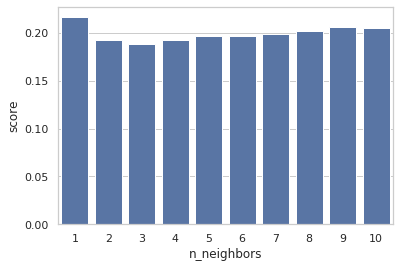

In [50]:
lst = []
for k in range(1, 11):
    lst.append([k, get_average_score((X_fold1, X_fold2, X_fold3), (y_fold1, y_fold2, y_fold3), k, 'minkowski')])

df = pd.DataFrame(data=lst, columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

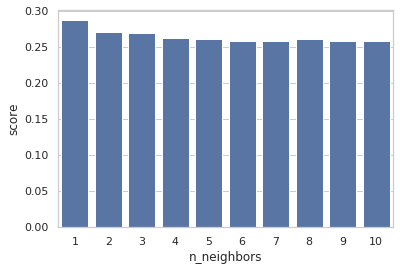

In [51]:
lst = []
for k in range(1, 11):
    lst.append([k, get_average_score((X_fold1, X_fold2, X_fold3), (y_fold1, y_fold2, y_fold3), k, 'cosine')])

df = pd.DataFrame(data=lst, columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

In [53]:
transformer = TfidfTransformer()
t_docs = transformer.fit_transform(docs, new_target)
X_fold12, X_fold3, y_fold12, y_fold3 = train_test_split(t_docs, new_target, test_size=0.33, shuffle=False)
X_fold1, X_fold2, y_fold1, y_fold2 = train_test_split(X_fold12, y_fold12, train_size=0.5, shuffle=False)

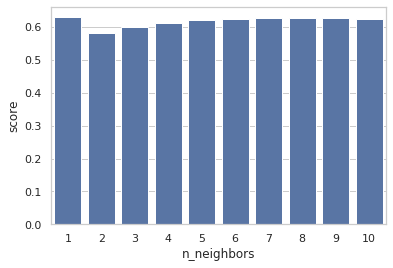

In [54]:
lst = []
for k in range(1, 11):
    lst.append([k, get_average_score((X_fold1, X_fold2, X_fold3), (y_fold1, y_fold2, y_fold3), k, 'minkowski')])

df = pd.DataFrame(data=lst, columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')

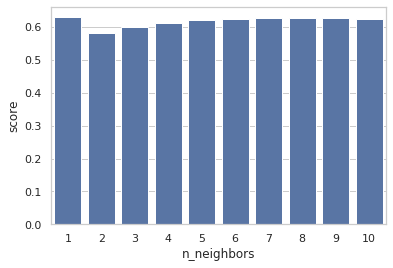

In [55]:
lst = []
for k in range(1, 11):
    lst.append([k, get_average_score((X_fold1, X_fold2, X_fold3), (y_fold1, y_fold2, y_fold3), k, 'cosine')])

df = pd.DataFrame(data=lst, columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [56]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [57]:
data = newsgroups['data']
target = newsgroups['target']
import re
tmp = list(
    filter(
        lambda tup: len(tup[0]) != 0,
        zip(
            map(
                lambda s: s.split(),
                map(
                    lambda s: re.sub(r"\W", " ", s),
                    map(lambda s: s.lower(), data)
                )
            ),
            target
        )
    )
)

data_tok_test = []
target_test = []
for text, tg in tmp:
    data_tok_test.append(text)
    target_test.append(tg)

In [58]:
indptr = [0]
indices = []
data = []
# dct = {}
for doc in data_tok_test:
    for word in doc:
        if word in dct:
            index = dct.setdefault(word, len(dct))
            indices.append(index)
            data.append(1)
    indptr.append(len(indices))

docs = csr_matrix((data, indices, indptr), dtype=int)

In [59]:
test_docs = transformer.transform(docs)

In [61]:
clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='cosine')
clf.fit(t_docs, np.asarray(new_target))
clf.score(test_docs, np.asarray(target_test))

0.5409768778218634

Качество отличается. Хочется объяснить это переобучением. Также это может быть связано с тем, что пришлось проигнорировать некоторые слова в тестовой выборке из-за использования TfidTransformer: из тестовых текстов взяты только те слова, которые были в обучаюшей выборке. Возможно, были выкинуты какие-то достаточно важные слова.